In [4]:
from load_modules import *
import my_config
import time
# K.clear_session()
os.environ["OPENCV_IO_ENABLE_OPENEXR"]="1"

In [1]:
if my_config.USE_GPU:
    physical_devices = tf.config.list_physical_devices('GPU')
    #set memory amount to half of GPU
    if len(physical_devices) > 0:
        for device in physical_devices:
            print("Device:", device)
    else:
        print("No GPU devices found.")
    # Set GPU memory growth
    gpus = tf.config.experimental.list_physical_devices('GPU')
    if gpus:
        try:
            for gpu in gpus:
                tf.config.experimental.set_memory_growth(gpu, True)
                
        except RuntimeError as e:
            print(e)

    # Test for GPU device name
    name = tf.test.gpu_device_name()
    if name != '/device:GPU:0':
        raise SystemError('GPU device not found')
    print('Found GPU at: {}'.format(name))
    # Print the number of available GPUs
    print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
else:
    print("No GPU")

NameError: name 'my_config' is not defined

In [12]:
encoder_path = r"/Users/joeljohnson/Documents/Encoder_Decoder/AE_2023_06/TrainedModels/316/encoder.h5"
decoder_path = r"/Users/joeljohnson/Documents/Encoder_Decoder/AE_2023_06/TrainedModels/316/decoder.h5"
encoder = load_model(encoder_path)
decoder = load_model(decoder_path)

print("Loaded models")
print("Encoder summary:" + str(encoder.summary()))
print("Decoder summary:" + str(decoder.summary()))
def encode(img):
    image = np.asarray(img).reshape(-1,3).astype('float32')
    # pred_maps = encoder.predict(image)
    start = time.time()
    pred_maps = None
    with tf.device('/device:GPU:0'):
        pred_maps = encoder.predict_on_batch(image)
    end = time.time()
    elapsed = end - start
    return pred_maps, elapsed
 
def decode(encoded):
    # recovered = decoder.predict(encoded)
    start = time.time()
    recovered = None
    with tf.device('/device:GPU:0'):
        recovered = decoder.predict_on_batch(encoded)
    end = time.time()
    elapsed = end - start
    # recovered = np.clip(recovered, 0, 1)
    return recovered, elapsed

Loaded models
Model: "encoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder_input (InputLayer)  [(None, 3)]               0         
                                                                 
 encoder_dense_0 (Dense)     (None, 75)                300       
                                                                 
 encoder_dense_2 (Dense)     (None, 75)                5700      
                                                                 
 encoder_output (Dense)      (None, 5)                 380       
                                                                 
Total params: 6,380
Trainable params: 6,380
Non-trainable params: 0
_________________________________________________________________
Encoder summary:None
Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 deco

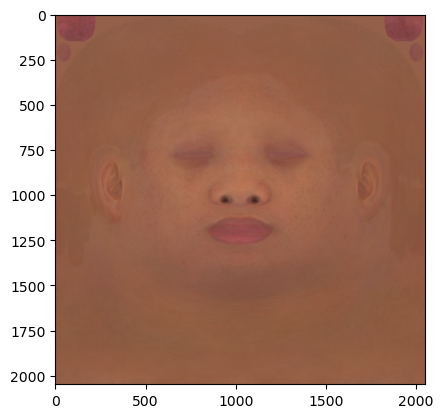

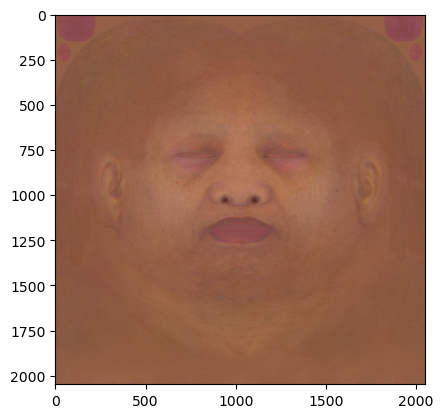

width = 2048


2023-07-25 18:22:26.398816: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


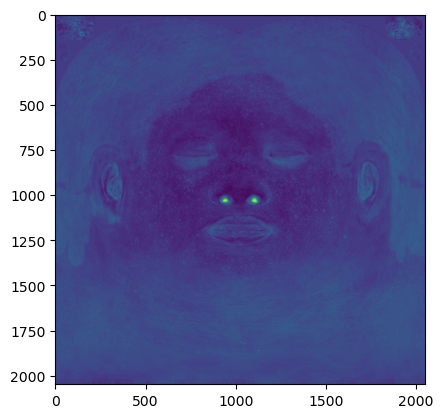

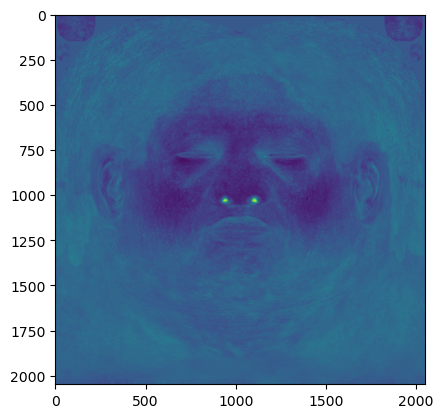

In [13]:
#load neutral image
neutral_path = r"meta46/neutral/FaceColor_MAIN.PNG"
aged_path = r"meta46/old/FaceColor_MAIN.PNG"
WIDTH = 2048
HEIGHT = 2048
#display neutral image
neutral_image = Image.open(neutral_path).resize((WIDTH,HEIGHT))

plt.imshow(neutral_image)
plt.show()
#display aged image
aged_image = Image.open(aged_path).resize((WIDTH,HEIGHT))
plt.imshow(aged_image)
plt.show()
print(f"width = {WIDTH}")

#encode neutral image
WIDTH = neutral_image.size[0]
HEIGHT = neutral_image.size[1]
neutral_image = np.asarray(neutral_image)/255.0
neutral_image = neutral_image[:, :, :3]  # keep only R, G, and B channels

neutral_pred_maps, neutral_encode_time = encode(neutral_image)
neutral_Cm = np.asarray(neutral_pred_maps[:,0])
neutral_Ch = np.asarray(neutral_pred_maps[:,1])
neutral_Bm = np.asarray(neutral_pred_maps[:,2])
neutral_Bh = np.asarray(neutral_pred_maps[:,3])
neutral_T = np.asarray(neutral_pred_maps[:,4])

#encode aged image
WIDTH = aged_image.size[0]
HEIGHT = aged_image.size[1]
aged_image = np.asarray(aged_image)/255.0
aged_image = aged_image[:, :, :3]
aged_pred_maps, aged_encode_time = encode(aged_image)
aged_Cm = np.asarray(aged_pred_maps[:,0])
aged_Ch = np.asarray(aged_pred_maps[:,1])
aged_Bm = np.asarray(aged_pred_maps[:,2])
aged_Bh = np.asarray(aged_pred_maps[:,3])
aged_T = np.asarray(aged_pred_maps[:,4])
#show Melanin maps
plt.imshow(neutral_Cm.reshape((WIDTH, HEIGHT)))
plt.show()
plt.imshow(aged_Cm.reshape((WIDTH, HEIGHT)))
plt.show()
#save aged pred maps to csv
header = ["Cm", "Ch", "Bm", "Bh", "T"]
np.savetxt("aged_pred_maps.csv", aged_pred_maps, delimiter=",", header="Cm, Ch, Bm, Bh, T", comments="")
#save neutral pred maps to csv
header = ["Cm", "Ch", "Bm", "Bh", "T"]
np.savetxt("neutral_pred_maps.csv", neutral_pred_maps, delimiter=",", header="Cm, Ch, Bm, Bh, T", comments="")


In [5]:
#load aged pred maps from csv
aged_pred_maps = pd.read_csv("aged_pred_maps.csv")
neutral_pred_maps = pd.read_csv("neutral_pred_maps.csv")
#print headers
print(aged_pred_maps.head())
print(neutral_pred_maps.head())
# import tensorflow as tf
# from tensorflow.keras import Sequential
# from tensorflow.keras.layers import Dense

# Define the model
model = Sequential([
    Dense(65, activation='relu', input_shape=(5,)),  # Input layer (5 features: 'Cm', 'Ch', 'Bm', 'Bh', 'T')
    Dense(65, activation='relu'),  # Hidden layer
    Dense(5, activation='linear')  # Output layer (5 predictions: 'Cm', 'Ch', 'Bm', 'Bh', 'T')
])

# Compile the model
model.compile(optimizer='adam', 
              loss='mean_squared_error', 
              metrics=['mae'])

# Print the summary of the model
model.summary()
x = neutral_pred_maps
y = aged_pred_maps
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.1, random_state=42, shuffle=True)
with tf.device('/device:GPU:0'):
    history = model.fit(x_train, y_train, 
                        validation_data=(x_test, y_test), 
                        epochs=40, 
                        batch_size=4096)


         Cm        Ch       Bm        Bh         T
0  0.133195  0.117286  0.45665  0.628914  0.140636
1  0.133195  0.117286  0.45665  0.628914  0.140636
2  0.133195  0.117286  0.45665  0.628914  0.140636
3  0.133195  0.117286  0.45665  0.628914  0.140636
4  0.133195  0.117286  0.45665  0.628914  0.140636
         Cm        Ch       Bm       Bh         T
0  0.126237  0.122389  0.45762  0.62425  0.141782
1  0.126237  0.122389  0.45762  0.62425  0.141782
2  0.126237  0.122389  0.45762  0.62425  0.141782
3  0.126237  0.122389  0.45762  0.62425  0.141782
4  0.126237  0.122389  0.45762  0.62425  0.141782
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 65)                390       
                                                                 
 dense_1 (Dense)             (None, 65)                4290      
                                            

In [7]:
def age_mel(v, t, r=0.08):
    """
    v is original volume fraction of melanin
    t is number of decades
    r is rate of decline (typical is 8%)
    """
    v_prime = v-(t*r)*v
    return v_prime

def age_hem(v, t, r_Hbi=0.06, r_Hbe=0.1, zeta=0.5):
    """
    v is original volume fraction of hemoglobin
    t is number of decades
    r is rate of decline (typical is 6%)
    """
    v_prime = v-t*(r_Hbi+zeta*r_Hbe)*v
    return v_prime

m141_4k.png


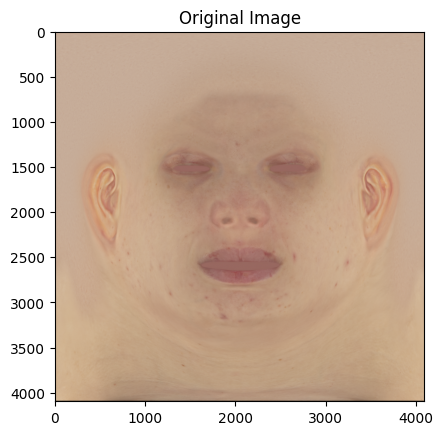

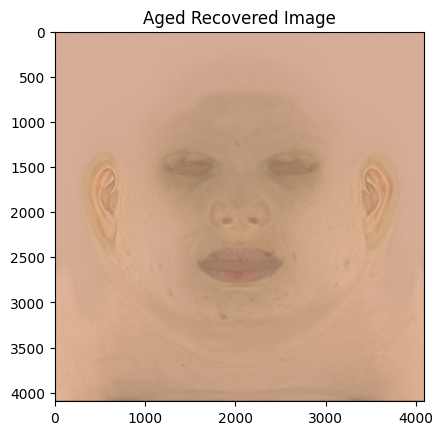

m46_4k.png


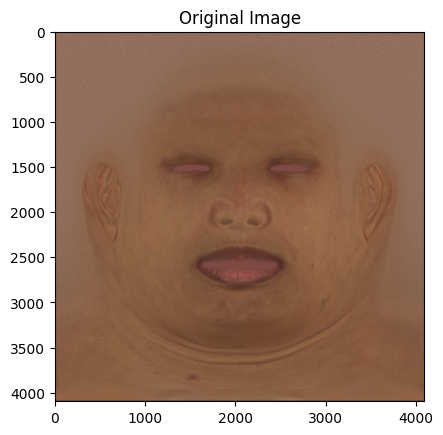

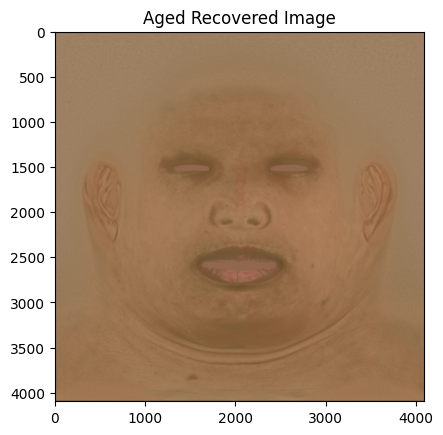

m53_4k.png


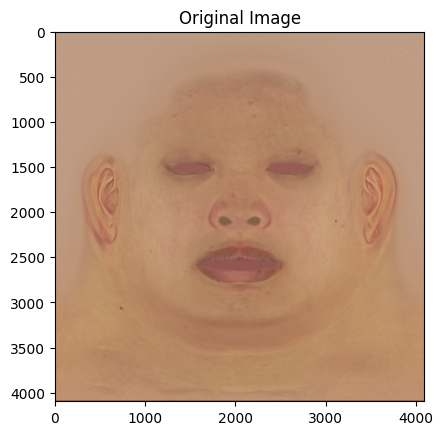

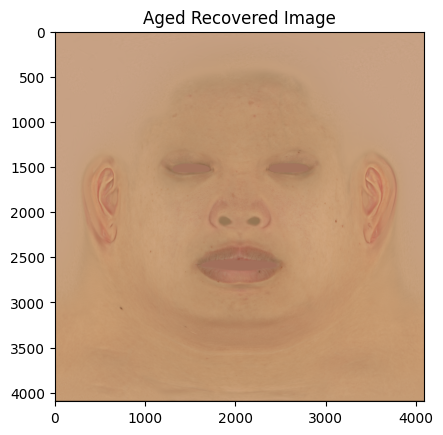

m64_4k.png


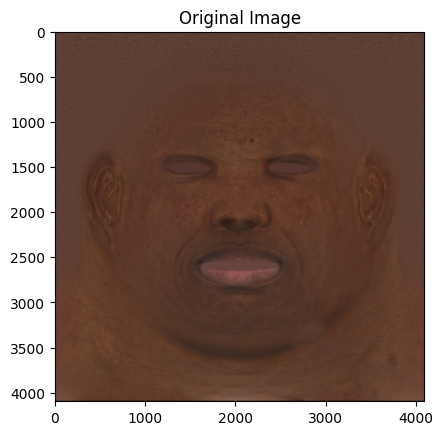

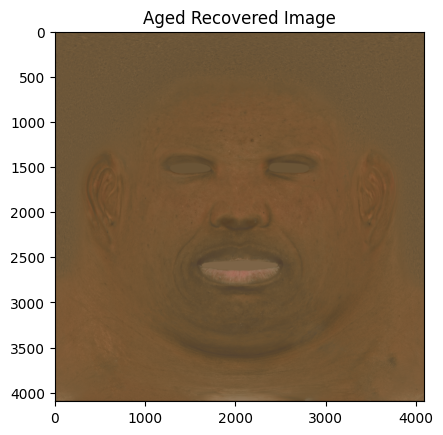

m98_4k.png


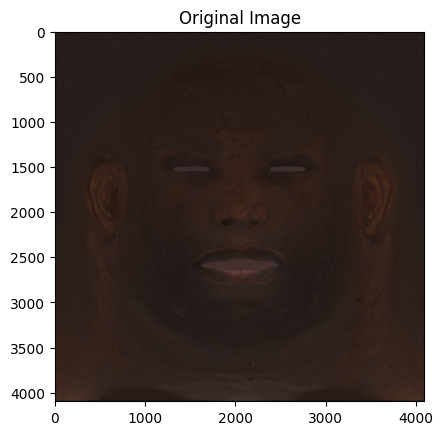

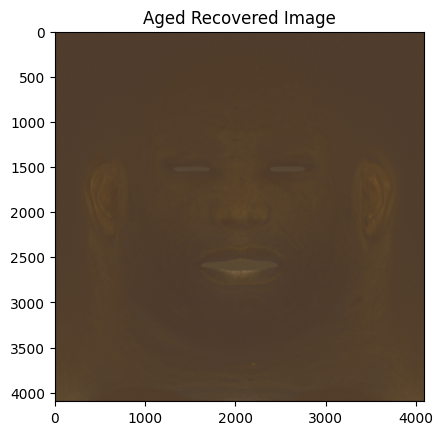

metina.png


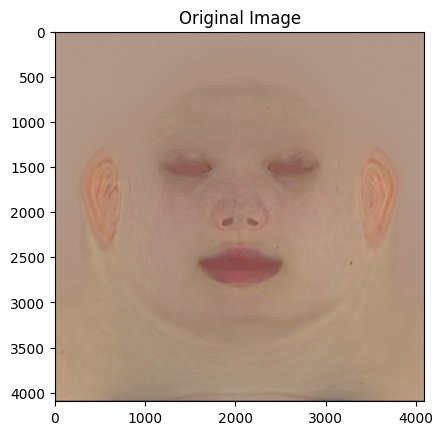

In [17]:
images_path = r"C:\Users\joeli\OneDrive\Desktop\AE_2023_06\models_4k"
for path in os.listdir(images_path):
    print(path)
    image = Image.open(os.path.join(images_path, path)).resize((4096,4096))
    image = np.asarray(image)/255.0
    pred_maps, encode_time = encode(image)
    pred_maps = np.asarray(pred_maps)
    # aged_pred_maps_prediction = model.predict_on_batch(pred_maps)
    Cm = pred_maps[:,0]
    Ch = pred_maps[:,1]
    pred_maps[:,0] = age_mel(pred_maps[:,0], 4)
    pred_maps[:,1] = age_hem(pred_maps[:,1], 4)
    pred_maps[:,3]*=0.98
    pred_maps[:,4]*=0.96
    aged_recovered, decode_time = decode(pred_maps)
    plt.imshow(image)
    plt.title("Original Image")
    plt.show()
    plt.imshow(aged_recovered.reshape((4096,4096,3)))
    plt.title("Aged Recovered Image")
    plt.show()
#loop through all images in meta46

#predict aged maps from neutral
with tf.device('/device:GPU:0'):
    aged_pred_maps_prediction = model.predict(neutral_pred_maps)
#decode aged maps
aged_recovered, aged_decode_time = decode(aged_pred_maps_prediction)
#show original image and  aged recovered image
plt.imshow(neutral_image)
plt.title("Original Image")
plt.show()
plt.imshow(aged_recovered.reshape((2048,2048,3)))
plt.title("Aged Recovered Image")
plt.show()